### 导入必要的包

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image


print('GPU is', 'available' if tf.test.is_gpu_available() else 'Not available')

GPU is available


In [2]:
tf.__version__

'2.0.0'

### 定义公共函数

In [3]:
def normalize_image(img):
    img = 255 * (img + 1.0) / 2.0
    
    return tf.cast(img, tf.uint8)

In [4]:
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [5]:
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

In [6]:
def read_image(file_name, max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

**tf.keras.applications包含了多种预训练的经典深度模型**  
由于不同大小图片的特征数量不同，因此我们利用 include_top=False 去掉顶层以此可以根据自己的需要决定输入的 shape，weights='imagenet' 表明 imagenet 样本训练出的模型的权重

### 公共 base_model

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### 单层单通道

指定层

In [8]:
layers_names = 'conv2d_23'
layers=base_model.get_layer(layers_names).output

print(layers)

Tensor("conv2d_23/Identity:0", shape=(None, None, None, 96), dtype=float32)


In [9]:
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
def calc_loss(img, model, channel):
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    act = layer_activations[:,:,:,channel]
    loss = tf.math.reduce_mean(act)
    
    return loss

In [11]:
def render_deepdream(model, img, channel, steps=100, step_size=0.01, verbose=2):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss(img, model, channel)
        gradients = tape.gradient(loss, img)
        
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        img += gradients * step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if (verbose == 2):
            if ((n + 1) % 10 == 0):
                print('Step {:3}/{:3}, loss {:4}'.format(n + 1, steps, loss))
            
    return img

In [12]:
img_noise = np.random.uniform(size=(300, 300, 3)) + 100.0
img_noise = img_noise.astype(np.float32)
img_Noise = img_noise.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

指定通道时，其值应在 channel 范围内

DeepDream is deepdreaming......
Step  10/100, loss 0.37168312072753906
Step  20/100, loss 0.9784045219421387
Step  30/100, loss 1.317335844039917
Step  40/100, loss 1.5503880977630615
Step  50/100, loss 1.7381901741027832
Step  60/100, loss 1.8932645320892334
Step  70/100, loss 2.027413845062256
Step  80/100, loss 2.139453411102295
Step  90/100, loss 2.24456524848938
Step 100/100, loss 2.3410422801971436
Wake up! 8.418466806411743 flies
DeepDream is saved!


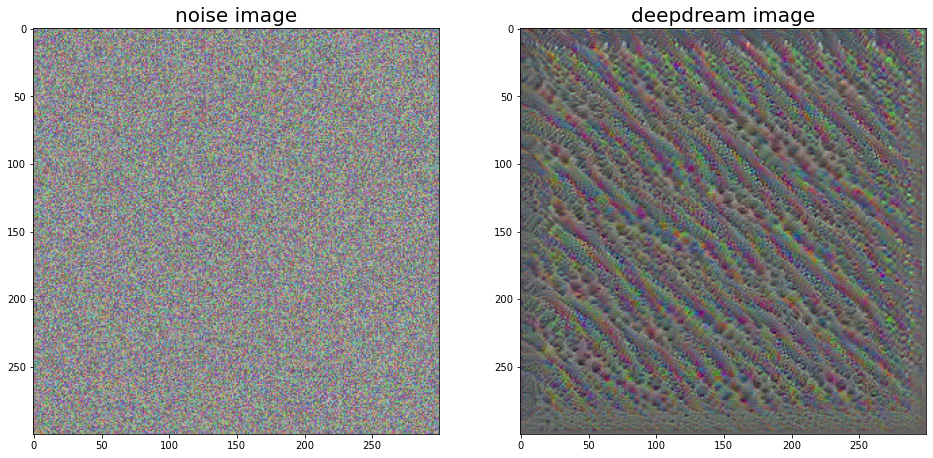

In [13]:
import time

startTime = time.time()
print('DeepDream is deepdreaming......')

dream_img = render_deepdream(dream_model, img, 10)

endTime = time.time()

print('Wake up! {} flies'.format(endTime-startTime))

dream_img = normalize_image(dream_img)

file_name = './data/deepdream_{}.jpg'.format(layers_names)
save_image(dream_img, file_name)
print('DeepDream is saved!'.format(file_name))

fig = plt.gcf()
fig.set_size_inches(16, 8)
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(normalize_image(img_Noise))
ax1.set_title('noise image', fontsize=20)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(dream_img)
ax2.set_title('deepdream image', fontsize=20)
plt.show()

### 单层多通道

In [14]:
layers_names = 'conv2d_23'
layers=base_model.get_layer(layers_names).output
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [15]:
def calc_loss(img, model, channels):
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    
    losses = []
    for cn in channels:
        act = layer_activations[:,:,:,cn]
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    
    return tf.reduce_sum(losses)

In [16]:
def render_deepdream(model, img, channels, steps=100, step_size=0.01, verbose=2):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss(img, model, [10, 20])
        gradients = tape.gradient(loss, img)
        
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        img += gradients * step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if (verbose == 2):
            if ((n + 1) % 10 == 0):
                print('Step {:3}/{:3}, loss {:4}'.format(n + 1, steps, loss))
            
    return img

In [17]:
img_noise = np.random.uniform(size=(300, 300, 3)) + 100.0
img_noise = img_noise.astype(np.float32)
img_Noise = img_noise.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

DeepDream is deepdreaming......
Step  10/100, loss 1.8195652961730957
Step  20/100, loss 2.877413749694824
Step  30/100, loss 3.53367280960083
Step  40/100, loss 4.005433082580566
Step  50/100, loss 4.389712333679199
Step  60/100, loss 4.730706214904785
Step  70/100, loss 5.0415239334106445
Step  80/100, loss 5.3287835121154785
Step  90/100, loss 5.600303649902344
Step 100/100, loss 5.864288330078125
Wake up! 5.1971118450164795 flies
DeepDream is saved!


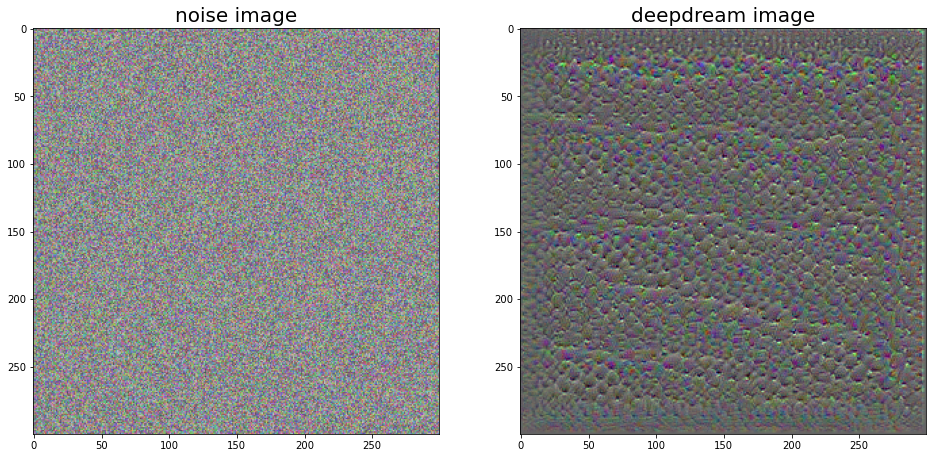

In [18]:
import time

startTime = time.time()
print('DeepDream is deepdreaming......')

dream_img = render_deepdream(dream_model, img, 10)

endTime = time.time()

print('Wake up! {} flies'.format(endTime-startTime))

dream_img = normalize_image(dream_img)

file_name = './data/deepdream_{}.jpg'.format(layers_names)
save_image(dream_img, file_name)
print('DeepDream is saved!'.format(file_name))

fig = plt.gcf()
fig.set_size_inches(16, 8)
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(normalize_image(img_Noise))
ax1.set_title('noise image', fontsize=20)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(dream_img)
ax2.set_title('deepdream image', fontsize=20)
plt.show()

### 多层全通道

**此处 dream_model 也适用于后面两个背景图像**

In [19]:
layers_names = ['conv2d_23', 'mixed5']
layers = [base_model.get_layer(name).output for name in layers_names]
for i in range(len(layers)):
    print(layers[i])

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

Tensor("conv2d_23/Identity:0", shape=(None, None, None, 96), dtype=float32)
Tensor("mixed5/Identity:0", shape=(None, None, None, 768), dtype=float32)


In [20]:
def calc_loss(img, model):
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [21]:
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=2):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss(img, model)
        gradients = tape.gradient(loss, img)
        
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        img += gradients * step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if (verbose == 2):
            if ((n + 1) % 10 == 0):
                print('Step {:3}/{:3}, loss {}'.format(n + 1, steps, loss))
            
    return img

In [22]:
img_noise = np.random.uniform(size=(300, 300, 3)) + 100.0
img_noise = img_noise.astype(np.float32)
img_Noise = img_noise.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

DeepDream is deepdreaming......
Step  10/100, loss 0.29908475279808044
Step  20/100, loss 0.5156078338623047
Step  30/100, loss 0.7052187323570251
Step  40/100, loss 0.870996356010437
Step  50/100, loss 1.0650714635849
Step  60/100, loss 1.2940750122070312
Step  70/100, loss 1.4968801736831665
Step  80/100, loss 1.7075774669647217
Step  90/100, loss 1.9374886751174927
Step 100/100, loss 2.1055333614349365
Wake up! 11.016572713851929 flies
DeepDream is saved!


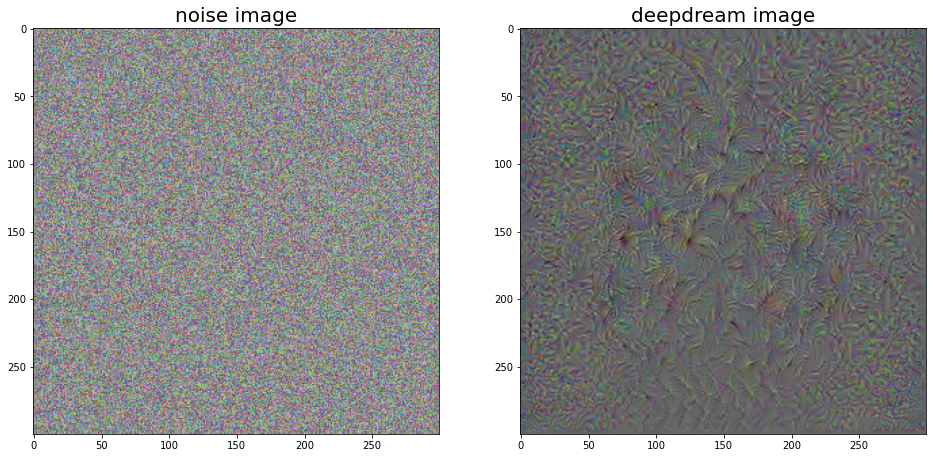

In [23]:
import time

startTime = time.time()
print('DeepDream is deepdreaming......')

dream_img = render_deepdream(dream_model, img)

endTime = time.time()

print('Wake up! {} flies'.format(endTime-startTime))

dream_img = normalize_image(dream_img)

file_name = './data/deepdream_{}.jpg'.format(layers_names)
save_image(dream_img, file_name)
print('DeepDream is saved!'.format(file_name))

fig = plt.gcf()
fig.set_size_inches(16, 8)
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(normalize_image(img_Noise))
ax1.set_title('noise image', fontsize=20)

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(dream_img)
ax2.set_title('deepdream image', fontsize=20)
plt.show()

### 背景图像

In [24]:
def calc_loss(img, model):
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [25]:
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=2):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss(img, model)
        gradients = tape.gradient(loss, img)
        
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        img += gradients * step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if (verbose == 2):
            if ((n + 1) % 10 == 0):
                print('Step {:3}/{:3}, loss {}'.format(n + 1, steps, loss))
            
    return img

In [26]:
layers_names = ['conv2d_23', 'mixed5']
layers = [base_model.get_layer(name).output for name in layers_names]
for i in range(len(layers)):
    print(layers[i])

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

Tensor("conv2d_23/Identity:0", shape=(None, None, None, 96), dtype=float32)
Tensor("mixed5/Identity:0", shape=(None, None, None, 768), dtype=float32)


In [27]:
img_scene = read_image('./data/uestc.jpg')
img_scene = img_scene.astype(np.float32)
img_Scene = img_scene.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_scene)
img = tf.convert_to_tensor(img)

DeepDream is deepdreaming......
Step  10/400, loss 0.09298734366893768
Step  20/400, loss 0.24137751758098602
Step  30/400, loss 0.3336787521839142
Step  40/400, loss 0.4055805802345276
Step  50/400, loss 0.46549665927886963
Step  60/400, loss 0.5207889676094055
Step  70/400, loss 0.5699973702430725
Step  80/400, loss 0.6171151399612427
Step  90/400, loss 0.653640866279602
Step 100/400, loss 0.6943302154541016
Step 110/400, loss 0.7312059998512268
Step 120/400, loss 0.7702720761299133
Step 130/400, loss 0.8076008558273315
Step 140/400, loss 0.8459428548812866
Step 150/400, loss 0.8861863613128662
Step 160/400, loss 0.9219092726707458
Step 170/400, loss 0.9596524238586426
Step 180/400, loss 0.9966444373130798
Step 190/400, loss 1.0375070571899414
Step 200/400, loss 1.0739365816116333
Step 210/400, loss 1.1114788055419922
Step 220/400, loss 1.1500513553619385
Step 230/400, loss 1.1858978271484375
Step 240/400, loss 1.2259176969528198
Step 250/400, loss 1.2619391679763794
Step 260/400, lo

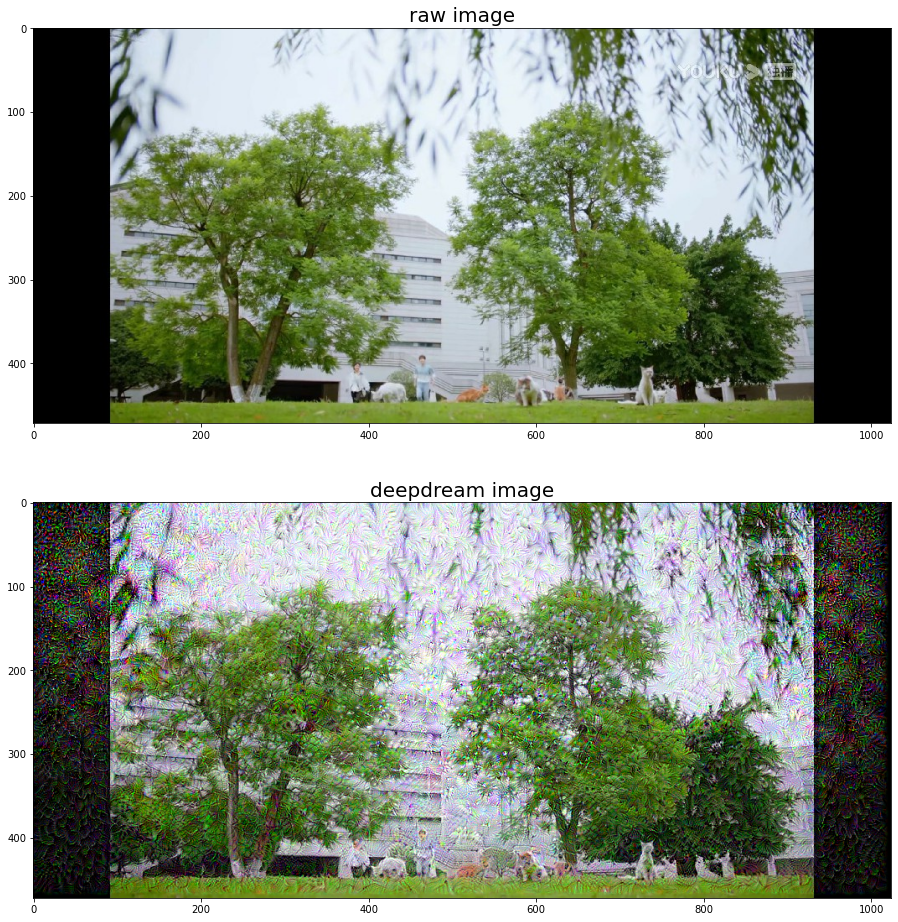

In [28]:
import time

startTime = time.time()
print('DeepDream is deepdreaming......')

dream_img = render_deepdream(dream_model, img, steps=400)

endTime = time.time()

print('Wake up! {} flies'.format(endTime-startTime))

dream_img = normalize_image(dream_img)

file_name = './data/deepdream_{}.jpg'.format(layers_names)
save_image(dream_img, file_name)
print('DeepDream is saved!'.format(file_name))

fig = plt.gcf()
fig.set_size_inches(16, 16)
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img_Scene.astype('uint8'))
ax1.set_title('raw image', fontsize=20)

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(dream_img)
ax2.set_title('deepdream image', fontsize=20)
plt.show()

### 背景图像过程优化1
采取由小到大的方式生成，先将图像缩小指定倍数，进行 Deepdream 后，放大一次，再进行 Deepdream，如此循环几次

In [29]:
img_scene = read_image('./data/uestc.jpg')
img_Scene = img_scene.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_scene)
img = tf.convert_to_tensor(img)

Step  10/ 50, loss 0.1253846138715744
Step  20/ 50, loss 0.28544867038726807
Step  30/ 50, loss 0.3829663395881653
Step  40/ 50, loss 0.4530993700027466
Step  50/ 50, loss 0.5086963176727295
Step  10/ 50, loss 0.31151697039604187
Step  20/ 50, loss 0.4383772909641266
Step  30/ 50, loss 0.5194989442825317
Step  40/ 50, loss 0.5801485180854797
Step  50/ 50, loss 0.6286039352416992
Step  10/ 50, loss 0.35074129700660706
Step  20/ 50, loss 0.4853087365627289
Step  30/ 50, loss 0.5703152418136597
Step  40/ 50, loss 0.6327226161956787
Step  50/ 50, loss 0.6832340955734253
Step  10/ 50, loss 0.37902626395225525
Step  20/ 50, loss 0.5169548392295837
Step  30/ 50, loss 0.6002033948898315
Step  40/ 50, loss 0.6597338914871216
Step  50/ 50, loss 0.7072175741195679
Step  10/ 50, loss 0.39113712310791016
Step  20/ 50, loss 0.5287901163101196
Step  30/ 50, loss 0.6115886569023132
Step  40/ 50, loss 0.6704986691474915
Step  50/ 50, loss 0.7165963053703308


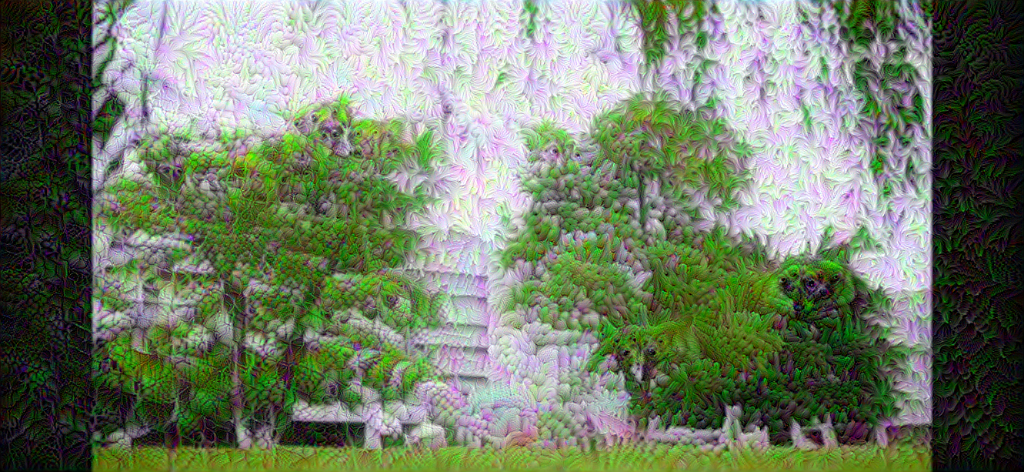

Total time: -69.93595671653748


In [30]:
import time
startTime = time.time()

OCTAVE_SCALE = 1.30

img = tf.keras.applications.inception_v3.preprocess_input(img_scene)
img = tf.convert_to_tensor(img)

initial_shape = tf.shape(img)[:-1]

for octave in range(-3, 2):
    new_size = tf.cast(tf.convert_to_tensor(initial_shape), 
                       tf.float32) * (OCTAVE_SCALE ** octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))   
    img = render_deepdream(dream_model, img, steps=50, step_size=0.01)

img = tf.image.resize(img, initial_shape)
img = normalize_image(img)

show_image(img)

endTime = time.time()
print('Total time:', startTime - endTime)

### 背景图像过程优化2
在**背景图像过程优化1**基础上，增加了块状计算方式，这样再大的图像也能进行分块运算，最后再合成

In [31]:
img_scene = read_image('./data/test.jpg')
img_Scene = img_scene.copy()
img = tf.keras.applications.inception_v3.preprocess_input(img_scene)
img = tf.convert_to_tensor(img)

相比于 `背景图像过程优化1`，此处重新定义了 calc_loss，并重命名为 calc_loss_optimization，其目的是增加了 tf.image.resize 操作，在我们按块操作时，最后剩余的图像尺寸可能不够进行提取模型的一系列操作，所以我们对其进行放大，为最大限度减小误差，我们放大的尺寸与块状尺寸相同，如果不进行此操作，在不同的 dream_model 层，不同的  octave 与 octave_scale，可能出现报错为:  
`Check failed: cudnnSetTensorNdDescriptor(handle_.get(), elem_type, nd, dims.data(), strides.data()) == CUDNN_STATUS_SUCCESS (3 vs. 0)batch_descriptor: {count: 1 feature_map_count: 192 spatial: 0 61  value_min: 0.000000 value_max: 0.000000 layout: BatchYXDepth}`

In [32]:
def calc_loss_optimization(img, model, size):
    img = tf.image.resize(img, tf.cast([size, size], tf.int32))
    img = tf.expand_dims(img, axis=0)
    layer_activations = model(img)
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [33]:
def random_roll(img, maxroll=512):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0], shift[1]
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    
    return shift_down, shift_right, img_rolled

In [34]:
def get_tiled_gradients(model, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)
    
    gradients = tf.zeros_like(img_rolled)
    
    xs = tf.range(0, img_rolled.shape[0], tile_size)
    ys = tf.range(0, img_rolled.shape[1], tile_size)
    
    for x in xs:
        for y in ys:
            with tf.GradientTape() as tape:
                tape.watch(img_rolled)
                img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                loss = calc_loss_optimization(img_tile, model, tile_size)
                gradients = gradients + tape.gradient(loss, img_rolled)
        
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
    
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    
    return gradients

In [35]:
def render_deepdream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                     octaves=range(-3, -1), octave_scale=1.3):
    
    initial_shape = img.shape[:-1]
    
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(initial_shape), tf.float32) * (octave_scale ** octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
        
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(model, img)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            
            if ((step + 1) % 10 == 0):
                print('Octave {}, Step {}'.format(octave, step + 1))
        
    img = tf.image.resize(img, initial_shape)
    result = normalize_image(img)
            
    return result

DeepDream is deepdreaming......
Octave -3, Step 10
Octave -3, Step 20
Octave -3, Step 30
Octave -3, Step 40
Octave -3, Step 50
Octave -2, Step 10
Octave -2, Step 20
Octave -2, Step 30
Octave -2, Step 40
Octave -2, Step 50
Octave -1, Step 10
Octave -1, Step 20
Octave -1, Step 30
Octave -1, Step 40
Octave -1, Step 50
Octave 0, Step 10
Octave 0, Step 20
Octave 0, Step 30
Octave 0, Step 40
Octave 0, Step 50
Octave 1, Step 10
Octave 1, Step 20
Octave 1, Step 30
Octave 1, Step 40
Octave 1, Step 50


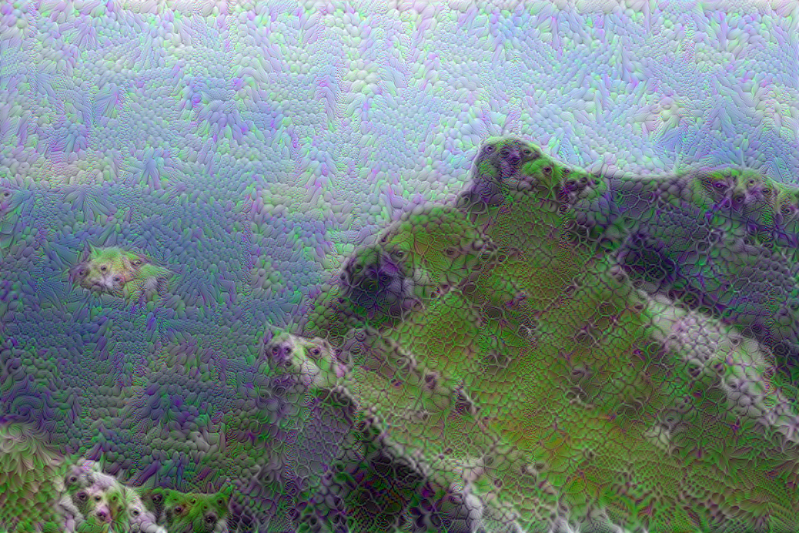

Total time: 115.36939454078674
Deepdream is saved!


In [36]:
import time
startTime = time.time()

print('DeepDream is deepdreaming......')

img = render_deepdream_with_octaves(dream_model, img, steps_per_octave=50,
                                    step_size=0.01, octaves=range(-3, 2), octave_scale=1.3)

show_image(img)

endTime = time.time()
print('Total time:', endTime - startTime)
file_name = './data/uestc_deepdream.jpg'
save_image(img, file_name)
print('Deepdream is saved!')